In [1]:
!pip install livelossplot --quiet

In [2]:
import os
import torch
import torchvision
import tarfile
import livelossplot
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, DataLoader

from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

import matplotlib.pyplot as plt

In [3]:
## Set seed
seed = 1211
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
# Dowload the dataset
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [5]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train', 'labels.txt']
['dog', 'airplane', 'automobile', 'truck', 'horse', 'frog', 'cat', 'bird', 'ship', 'deer']


In [6]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['29189_airplane.png', '16548_airplane.png', '13069_airplane.png', '24676_airplane.png', '9292_airplane.png']


In [7]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['5338_ship.png', '613_ship.png', '3289_ship.png', '6474_ship.png', '6179_ship.png']


In [8]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [9]:
## Load Data and create pytorch dataset
train_ds = ImageFolder(data_dir+'/train', transform= train_tfms)
test_ds = ImageFolder(data_dir+'/test', transform= test_tfms)

In [10]:
## Classes and its indxes 
print(train_ds.classes)
print("Index :", train_ds.class_to_idx)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Index : {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [11]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  airplane (0)


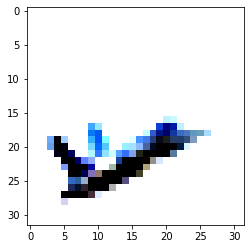

In [12]:
show_example(*train_ds[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  airplane (0)


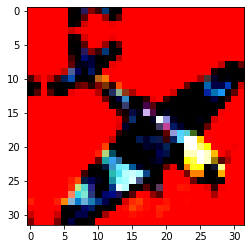

In [13]:
show_example(*train_ds[199])

In [14]:
## Lets create validation set
val_size = 5000
train_size = len(train_ds) - val_size
train_size, val_size

(45000, 5000)

In [15]:
train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [16]:
def conv_block(input_channel, out_channel, pool = False):

  layers = [
            nn.Conv2d(input_channel, out_channel, kernel_size= 3, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace = True)
  ]

  if pool:
    layers.append(nn.MaxPool2d(kernel_size=2))

  return nn.Sequential(*layers)



class Cifar10ResNet(nn.Module):
    def __init__(self, input_channel, num_classes):
        super(Cifar10ResNet,self).__init__()

        self.conv1 = conv_block(input_channel, 64)
        self.conv2 = conv_block(64,128, pool = True)
        self.res1 = nn.Sequential(conv_block(128,128), conv_block(128,128))

        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256,512, pool = True)
        self.res2 = nn.Sequential(conv_block(512,512), conv_block(512,512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(), 
                                        nn.Linear(2048, num_classes))
        
          
        
    def forward(self, inputs):
        out = self.conv1(inputs)
        # print("1 :", out.shape)
        out = self.conv2(out)
        # print("2 :", out.shape)
        out = self.res1(out) + out
        # print("3 :", out.shape)
        out = self.conv3(out)
        # print("4 :", out.shape)
        out = self.conv4(out)
        # print("5 :", out.shape)
        out = self.res2(out) + out
        # print("6 :", out.shape)
        out = self.classifier(out)
        return out

In [17]:
def save_model(model_path, model_name, model, optimizer, logs, epoch):
    model_dict = {
        "model": model.state_dict(),
        "optimizer":optimizer.state_dict(),
        "logs":logs,
        "epoch":epoch
    }
    
    os.makedirs(model_path, exist_ok=True)
    model_file_path = os.path.join(model_path,model_name)
    torch.save(model_dict,model_file_path)

def evaluate(model, inputs):
    
    model.eval()
    outputs = model(inputs.float())
    
    preds = F.softmax(outputs)
    preds = torch.argmax(preds, axis=1)
    return preds

def accuracy(preds, labels):
    acc = (torch.sum(preds==labels).item()/len(labels))*100
    return np.round(acc,3)

In [18]:
def train(model, dataloaders, loss_fn, optimizer, num_epochs, model_name):
    
    lossplot = livelossplot.PlotLosses()
    min_loss = 9999999
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ["train","validation"]:
            
            running_loss = 0.0
            running_accuracy = 0
            
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]:
                # inputs.to(device)
                # labels.to(device)
                outputs = model(inputs.float())
                loss = loss_fn(outputs, labels)
                
                running_loss += loss.item()
                
                preds = torch.argmax(outputs,axis=1)
                running_accuracy += torch.sum(preds==labels)
                
                
                if phase=="train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
            prefix = ''
            if phase=="validation":
                prefix ="val_"
            
            print("")
            epoch_loss = running_loss/len(dataloaders[phase])
            epoch_acc = running_accuracy.item()/len(dataloaders[phase].dataset)
                
            logs[prefix+'loss'] = np.round(epoch_loss,3)
            logs[prefix+'accuracy'] = np.round(epoch_acc,3)
            
            if phase == "validation":
                if epoch_loss<min_loss:
                    min_loss = epoch_loss
                    save_model('./model',model_name ,model, optimizer,logs, epoch)
        
        lossplot.update(logs)
        lossplot.send()

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dataset = dl.dataset
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


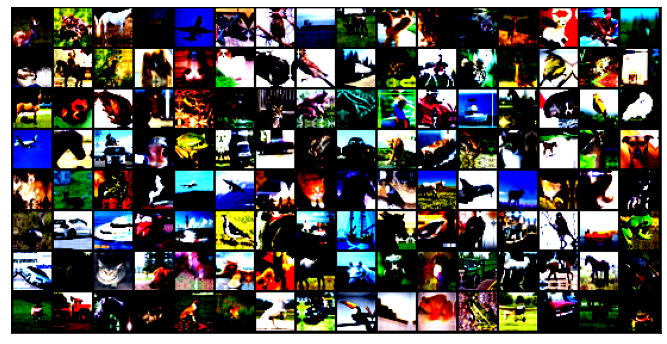

In [20]:
### Create Model Config
batch_size = 128
learning_rate = 0.001
epochs = 10
model_name = 'resnet_model.pth'

## Create dataloader 
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True) 
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [21]:
device = get_default_device()
print("Device :", device)


model = Cifar10ResNet(3, len(classes))
to_device(model, device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


dataloaders = {
    "train": train_dl,
    "validation" : val_dl
}

Device : cuda


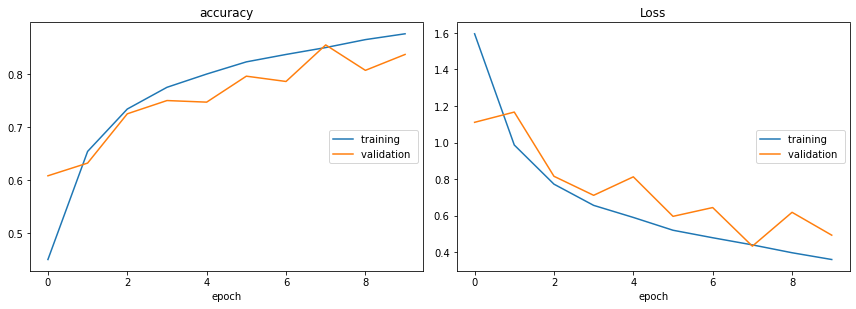

accuracy
	training         	 (min:    0.450, max:    0.876, cur:    0.876)
	validation       	 (min:    0.608, max:    0.855, cur:    0.837)
Loss
	training         	 (min:    0.361, max:    1.595, cur:    0.361)
	validation       	 (min:    0.434, max:    1.167, cur:    0.494)


In [22]:
train(model , dataloaders, loss_fn, optimizer, epochs, model_name)

In [23]:
del train_ds, train_dl, val_dl, val_ds

In [25]:
## Load model
model_file_path = './model/resnet_model.pth'
model_dict = torch.load(model_file_path)

model = Cifar10ResNet(3, len(classes))
model.load_state_dict(model_dict['model'])

<All keys matched successfully>

In [26]:
model.eval()
to_device(model,device)
running_accuracy = 0
for inputs, labels in test_dl:
  outputs = model(inputs.float())
  preds = torch.argmax(outputs,axis=1)
  running_accuracy += torch.sum(preds==labels)

acc = running_accuracy.item()/len(test_dl.dataset)
print("Test Accuracy :", acc)

Test Accuracy : 0.8632
